<a href="https://colab.research.google.com/github/viniciusvmda/procedural-texture/blob/master/gp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programação Genética
https://www.pyimagesearch.com/2014/07/14/3-ways-compare-histograms-using-opencv-python/

## Requisitos

In [1]:
# GP
!pip install deap
# Graphics
!apt-get install graphviz libgraphviz-dev pkg-config
!pip install pygraphviz networkx
# Noise functions
!pip install noise

     |████████████████████████████████| 153kB 5.1MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu2).
graphviz is already the newest version (2.40.1-2).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 8 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://archive

## Bibliotecas

In [0]:
# Genetic Programming
from deap import base, creator, gp, tools, algorithms
# Graphics
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib import pyplot as plt
# Computer vision
import cv2
from google.colab.patches import cv2_imshow
# Util
import numpy as np
import random
# Operators
from noise import snoise2
# Upload images
from google.colab import files
from io import BytesIO

## Desenvolvimento

### Inicialização de variáveis

In [0]:
toolbox = base.Toolbox()

### Imagem de referência

In [29]:
files.upload()

Saving ruined-texture.jpg to ruined-texture.jpg


{'ruined-texture.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x01\x00\x01\x00\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x03\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x04\x05\x06\x02\x01\x00\x07\xff\xc4\x00;\x10\x00\x02\x02\x01\x03\x02\x05\x02\x04\x04\x06\x02\x03\x01\x00\x03\x01\x02\x03\x11\x04\x00\x12!1A\x05\x13"Qaq\x81\x142\x91\xa1#B\xb1\xc1\x06\x15R\xd1\xe1\xf0$3Cb\xf1r5\x82\xa2\xff\xc4\x00\x18\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x02\x03\x04\xff\xc4\x00\x1e\x11\x01\x01\x01\x00\x02\x02\x03\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x11!1\x02A\x12Qaq\xff\xda\x00\x0c\x03\x01

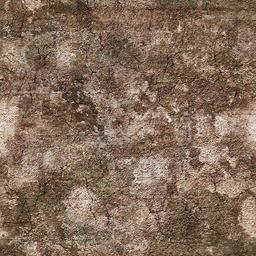

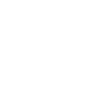

In [30]:
BASE_IMG = cv2.imread('ruined-texture.jpg')
cv2_imshow(BASE_IMG)

WHITE_IMG = np.full((100,100,3), 255, dtype=np.uint8)
cv2_imshow(WHITE_IMG)

### Gráficos

In [0]:
def plotTree(expr):
  nodes, edges, labels = gp.graph(expr)
  
  g = nx.DiGraph()
  g.add_nodes_from(nodes)
  g.add_edges_from(edges)
  pos = graphviz_layout(g, prog="dot")

  nx.draw_networkx_nodes(g, pos)
  nx.draw_networkx_edges(g, pos)
  nx.draw_networkx_labels(g, pos, labels)
  
  plt.show()
  
def plotImage(data):
  plt.axis("off")
  plt.imshow(data, cmap='binary')



### Algoritmo

#### Operadores

In [0]:
# https://docs.opencv.org/3.0-beta/modules/imgproc/doc/filtering.html
# https://docs.opencv.org/3.2.0/d0/d86/tutorial_py_image_arithmetics.html
# Simplex noise
def perlinNoise(scale=100, octaves=6):
  octavesNormalized = octaves % 6 + 1
  image = np.zeros((100, 100), dtype=np.uint8)
  width = image.shape[0]
  height = image.shape[1]
  output = np.zeros((width, height), dtype=np.uint8)
  for x in range(0, width):
    for y in range(0, height):
        noiseValue = snoise2(x/scale, y/scale, octaves=octavesNormalized, base=0)
        # Transform the value from [-1,1] to [0,255]
        output[x][y] = int((noiseValue + 1) * 127.5)
  return cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)


def addWeighted(img1, img2, weight):
  GAMMA = 0
  return cv2.addWeighted(img1, weight, img2, 1 - weight, GAMMA)

#### Fitness

In [0]:
def calculateHistogram(img):
  channels = [0, 1, 2]
  mask = None
  binsPerChannel = [8, 8, 8]
  rangesPerDimension = [0, 256, 0, 256, 0, 256]
  
  hist = cv2.calcHist([img], channels, mask, binsPerChannel, rangesPerDimension)
  hist = cv2.normalize(hist, hist).flatten()
  
  return hist;


def compareHistograms(img1, img2):
  hist1 = calculateHistogram(img1)
  hist2 = calculateHistogram(img2)
  d = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
  # d está no intervalo [0, 1]
  return d


def evalFitness(individual):
  # Transform the tree expression in a callable function
  img = toolbox.compile(expr=individual)
  return compareHistograms(BASE_IMG, img), # must return a tuple containing one element

#### Estrutura da árvore

In [31]:
#https://gist.github.com/macrintr/9876942

def _(a):
    return a

def rand100():
  return random.randrange(100) + 1

# Define input types and output type
pset = gp.PrimitiveSetTyped("main", [], np.ndarray)

# Add operators
pset.addPrimitive(perlinNoise, [int, int], np.ndarray)
pset.addPrimitive(addWeighted, [np.ndarray, np.ndarray, float], np.ndarray)
pset.addPrimitive(_, [float], float)
pset.addPrimitive(_, [int], int)

pset.addTerminal(WHITE_IMG, np.ndarray, "blank")

pset.addTerminal(100, int)
pset.addTerminal(80, int)
pset.addTerminal(60, int)
pset.addTerminal(40, int)
pset.addTerminal(20, int)

pset.addTerminal(0.0, float)
pset.addTerminal(0.1, float)
pset.addTerminal(0.2, float)
pset.addTerminal(0.3, float)
pset.addTerminal(0.4, float)
pset.addTerminal(0.5, float)


# Create individual and add tree with primitives
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, pset=pset, fitness=creator.FitnessMax)
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=4, max_=20)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

# Fitness Evaulation
toolbox.register("evaluate", evalFitness)
# Selection
toolbox.register("select", tools.selTournament, tournsize=3)
# Crossover
toolbox.register("mate", gp.cxOnePoint)
# Mutation
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


#### Testes

In [34]:
N_HALL_OF_FAME_INDIVIDUALS = 5
INITIAL_POPULATION_SIZE = 20
CROSSOVER_PROBABILITY = 0.6
MUTATION_PROBABILITY = 0.1
N_GENERATIONS = 100

random.seed(10)
pop = toolbox.population(n=INITIAL_POPULATION_SIZE)
hof = tools.HallOfFame(N_HALL_OF_FAME_INDIVIDUALS)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

algorithms.eaSimple(pop, toolbox, CROSSOVER_PROBABILITY, MUTATION_PROBABILITY, N_GENERATIONS, stats, halloffame=hof)

gen	nevals	avg        	std        	min       	max        
0  	20    	-0.00707408	0.000744863	-0.0095121	-0.00608966
1  	15    	-0.00658376	0.000349067	-0.00705166	-0.00597484
2  	13    	-0.00619785	0.000272346	-0.00669836	-0.00587594
3  	16    	-0.00601433	0.000152509	-0.00648043	-0.00576876
4  	12    	-0.00579361	0.000429861	-0.00596862	-0.00399364
5  	9     	-0.0057186 	0.000432692	-0.00610401	-0.00399364
6  	12    	-0.00533477	0.000705415	-0.00604194	-0.00399364
7  	15    	-0.00516285	0.000954589	-0.00662393	-0.0040386 
8  	16    	-0.00453281	0.000735133	-0.00637154	-0.00387312
9  	14    	-0.00463028	0.000997873	-0.00703823	-0.00387312
10 	15    	-0.00460349	0.000866356	-0.00703823	-0.0036579 
11 	9     	-0.0042377 	0.000667577	-0.00620294	-0.0036579 
12 	10    	-0.0039853 	0.000438936	-0.00524497	-0.0036579 
13 	11    	-0.0044121 	0.00114675 	-0.00784761	-0.00357158
14 	11    	-0.00426849	0.00110403 	-0.00659911	-0.00357158
15 	12    	-0.00435492	0.000893919	-0.00659911	-0.00357158

([[<deap.gp.Primitive at 0x7f8ee67e3ae8>,
 [{'avg': -0.007074083229920529,
   'gen': 0,
   'max': -0.00608966481661214,
   'min': -0.009512098490018647,
   'nevals': 20,
   'std': 0.0007448630148062754},
  {'avg': -0.0065837643524284135,
   'gen': 1,
   'max': -0.005974840555209479,
   'min': -0.00705165710702112,
   'nevals': 15,
   'std': 0.0003490670125918111},
  {'avg': -0.006197849791307032,
   'gen': 2,
   'max': -0.005875940452946406,
   'min': -0.006698359059582153,
   'nevals': 13,
   'std': 0.00027234634024415856},
  {'avg': -0.006014330318573443,
   'gen': 3,
   'max': -0.005768757694270523,
   'min': -0.006480426553061564,
   'nevals': 16,
   'std': 0.00015250910328224923},
  {'avg': -0.005793606730485018,
   'gen': 4,
   'max': -0.0039936412786901005,
   'min': -0.005968615826692864,
   'nevals': 12,
   'std': 0.0004298608591655873},
  {'avg': -0.005718597894503211,
   'gen': 5,
   'max': -0.0039936412786901005,
   'min': -0.006104006183176689,
   'nevals': 9,
   'std': 0.

addWeighted(blank, addWeighted(addWeighted(perlinNoise(60, 40), addWeighted(addWeighted(perlinNoise(40, 60), perlinNoise(_(40), 40), _(_(_(_(_(_(_(_(0.4))))))))), addWeighted(addWeighted(addWeighted(addWeighted(perlinNoise(_(40), 40), perlinNoise(_(40), _(_(60))), _(_(_(_(_(_(_(_(_(_(0.4))))))))))), perlinNoise(_(40), 40), _(_(_(_(_(_(_(_(0.4))))))))), addWeighted(perlinNoise(_(40), 40), perlinNoise(_(_(40)), _(_(60))), _(_(_(_(_(_(_(_(_(0.3)))))))))), 0.4), perlinNoise(_(80), _(_(_(60)))), _(_(_(_(_(_(_(_(_(0.3)))))))))), 0.4), 0.4), addWeighted(perlinNoise(20, _(40)), perlinNoise(_(_(_(_(_(100))))), _(_(40))), _(_(_(_(_(_(_(_(_(_(_(_(_(_(_(_(_(_(_(_(_(_(0.5))))))))))))))))))))))), _(_(_(_(_(_(_(_(_(_(_(_(_(_(_(_(_(_(_(0.4)))))))))))))))))))), _(_(_(_(0.4)))))


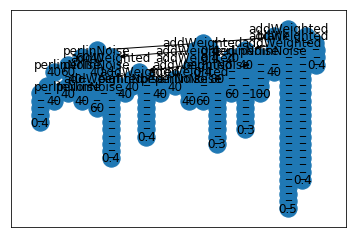

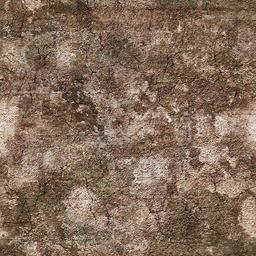

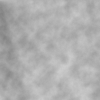

In [33]:
tree = gp.PrimitiveTree(hof[0])
compiledExpression = gp.compile(tree, pset)

print(hof[0])
plotTree(hof[0])
cv2_imshow(BASE_IMG)
cv2_imshow(compiledExpression)
